In [1]:
import numpy as np
import pandas as pd
import random as r
import math
import os
from datetime import timedelta
import statistics as stats 

import matplotlib.pyplot as plot
import matplotlib.ticker as mtick
import networkx as nx
import seaborn as sns

from pyomo.environ import *
from pyomo.opt import SolverFactory
#from gurobipy import GRB

In [2]:
#id directories
data_dir = os.getcwd().replace('/model', '/data')
results_dir = os.getcwd().replace('/model', '/results')
os.chdir(os.getcwd()+'/outputs/strategic_decisions')

#change from scientific to float
pd.set_option('display.float_format', lambda x: '%0.2f' % x)

In [3]:
#various budgets tested in beggining of forecasting period
budget_levels = list(range(5000000, 8000000+1, 1000000))
reliability_levels = [1,2] #best case, expected, worst case scenario

#to easily test various warehouse capacities if needed for example case
warehouse_cap_level = 3

#define sets
T_set = 12
K_set = 3
I_set = 4

I_k_dict = {1: [1,2],
            2: [1,2,3,4],
            3: [1,2,3,4]}

#labels for graphs
names_SKU = ['N95-MG', 'SUR-MG', 'K95-NMG', 'Misc-NMG']
names_commodity_type = ['Masks for Heath Care', 
                        'Masks for Businesses', 'Masks for the General Public']
reliability_level_names = ['EXPECTED demand projections', 'HIGH demand projections']

In [4]:
def initialize_model(reliability_level, 
                     budget_level):
    
    model = ConcreteModel()
    
    #define sets
    T_set = 12
    K_set = 3
    I_set = 4

    I_k_dict = {1: [1,2],
               2: [1,2,3,4],
               3: [1,2,3,4]}

    #####initialize sets#######
    model.K = Set(initialize = range(1,K_set+1))
    model.I = Set(initialize = range(1,I_set+1))
    model.T = Set(initialize = range(1,T_set+1))
    model.T_0 = Set(initialize = range(0,T_set+1)) #to calculate lead time distributions
    model.I_k = Set(model.K)
    for k in model.K:
        for i in range(0,len(I_k_dict[k])):
            model.I_k[k].add(I_k_dict[k][i])
    
    
    ####Healthcare commodity metric parameters
    r_k_dict = {
        1: 1.0,
        2: 0.5,
        3: 0.2
    }

    #suitability score (only specified for suitable items)
    q_k_i_dict = {
        tuple([1,1]):1,
        tuple([1,2]):.9,
        tuple([1,3]):0,
        tuple([1,4]):0,
        tuple([2,1]):.5,
        tuple([2,2]):.9,
        tuple([2,3]):.4,
        tuple([2,4]):.3,
        tuple([3,1]):.1,
        tuple([3,2]):.2,
        tuple([3,3]):.4,
        tuple([3,4]):.3
    }

    def rank_score_initialize(model, k):
        return(r_k_dict.get(k))

    model.r_k = Param(model.K, initialize = rank_score_initialize)

    def suitability_score_initialize(model, k, i):
        if (i in model.I_k[k]):
            return(q_k_i_dict.get(tuple([k,i])))
        else:
            return(None)

    model.q_k_i = Param(model.K, model.I, initialize = suitability_score_initialize)
    
    def healthcare_commodity_metric_initialize(model, k, i, t):
        if (i in model.I_k[k]):
            suitability_score = q_k_i_dict.get(tuple([k,i]))
            criticality_score = r_k_dict.get(k)
            phi_k_i_t_temp = suitability_score*(criticality_score*((1+criticality_score)**(T_set-t)))

            return(phi_k_i_t_temp)
        
        else:
            return(None)
        
    model.phi_k_i_t = Param(model.K, model.I, model.T, initialize = healthcare_commodity_metric_initialize)
    

    #######warehouse capacity parameters#######

    #size
    s_i_dict = {
        1: 1,
        2: 1,
        3: 1,
        4: 1
    }

    def item_size_param_initialize(model, i):
        return(s_i_dict.get(i))

    model.s_i = Param(model.I, initialize = item_size_param_initialize)
    
    #total warehouse capacity
    h = 50000*warehouse_cap_level

    model.h = Param(initialize = h)

    #######budget and cost parameters########

    #cost
    c_i_dict = {
        1: 24,
        2: 20,
        3: 14,
        4: 6
    }

    #budget
    b = budget_level

    def cost_param_initialize(model, i):
        return(c_i_dict.get(i))

    model.c_i = Param(model.I, initialize = cost_param_initialize)

    def budget_param_initialize(model):
        return(b)

    model.b = Param(initialize = budget_param_initialize)

    ########inventory availability parameters##########
    #starting inventory
    z_i_init_dict = {
        1 : 3000,
        2 : 4000,
        3 : 5000,
        4 : 5000
    }

    def beg_inv_param_initialize(model, i):
        return(z_i_init_dict.get(i))

    model.z_i_init = Param(model.I, initialize = beg_inv_param_initialize)
    
    #incoming orders
    o_i_t_init_dict = {}


    for i in range(1,I_set+1):
        for t in range(1,T_set+1):
            if t <= 2:
                o_i_t_init_dict[tuple([i,t])] = 0 
            else:
                o_i_t_init_dict[tuple([i,t])] = 0
                
    def incoming_orders_initialize(model, i, t):
        return(o_i_t_init_dict.get(tuple([i,t])))

    model.o_i_t_init = Param(model.I, model.T, initialize = incoming_orders_initialize)

    #######Supply parameters########
    #lead times
    lead_time_dictionary_supplier_SKU = {1: [2,4,3], #min, max, likely, a,b,c
                         2: [1,3,2], 
                         3: [1,5,2],
                         4: [0,1,1]}

    def lead_time_dist(a,b,c):
        lead_time_dist_array = np.zeros(T_set+1)
        cum_prob = 0
        t = 0

        while t < b+1:
            if t+1 <= a:
                t = t+1 
            elif (a < t+1 & t+1 <= c):
                cum_prob_temp = ((t+1-a)**2)/((b+1-a)*(c-a))
                prob = cum_prob_temp - cum_prob
                lead_time_dist_array[t] = prob
                cum_prob = cum_prob_temp
                t = t+1
            elif c < t+1 & t+1 <= b+1:
                cum_prob_temp = 1-((b+1-(t+1))**2)/((b+1-a)*(b+1-c))
                prob = cum_prob_temp - cum_prob
                lead_time_dist_array[t] = prob
                cum_prob = cum_prob_temp
                t = t+1

        return(lead_time_dist_array)

    f_i_l_dict = {}
    for i in model.I:
        lead_time_dist_array = lead_time_dist(lead_time_dictionary_supplier_SKU.get(i)[0],
                                             lead_time_dictionary_supplier_SKU.get(i)[1],
                                             lead_time_dictionary_supplier_SKU.get(i)[2])
        for t in model.T_0:
            f_i_l_dict[tuple([i,t])] = lead_time_dist_array[t]


    #supply capacities
    cap_dictionary_supplier_SKU = {1: np.repeat([20000,24000], [3,T_set-3]), #min, max, likely, a,b,c
                         2: np.repeat([30000,40000], [2,T_set-2]), 
                         3: [90000]*T_set,
                         4: [170000]*T_set}

    cap_dictionary_supplier_SKU_t = {}

    for i in model.I:
        for t in model.T:
            cap_dictionary_supplier_SKU_t[tuple([i,t])] = cap_dictionary_supplier_SKU[i][t-1]

    def delay_dist_param_initialize(model, i, t):
        return(f_i_l_dict.get(tuple([i,t])))

    model.f_i_l = Param(model.I, model.T_0, 
                              initialize = delay_dist_param_initialize)

    def supplier_cap_param_initialize(model, i, t):
        return(cap_dictionary_supplier_SKU_t[i,t])

    model.cap_i_t = Param(model.I, model.T, initialize = supplier_cap_param_initialize)

    ######demand parameters#########

    #unfulfilled demand
    n_k_init_dict = {
        1 : 0,
        2 : 0,
        3 : 0
    }
    

    #projected base incoming demand
    base_demand_k = {1: [7000, 10000, 14000],
                    2: [16000, 17000, 18000],
                    3: [22000, 21000, 22000]}

    #used in this example to adjust demand RV over time
    dynamic_adj_dem_t = {1: [0.5, 0.6, 0.7, 1, 1.1, 1.5, 1.6, 1.2, 1.1, 0.9, 0.8, 0.8],
                        2: [1.5, 1.5, 1.5, 1, 0.8, 0.8, 0.8, 0.8, 1, 1, 1, 1],
                        3: [1,1,1,1,1,1,1,1,1,1,1,1]}
    
    epsilon = reliability_level
    
    def demand_param_initialize(model,k, t):
        base_demand_k_temp = base_demand_k[k]
        adjust_demand_temp = dynamic_adj_dem_t[k][t-1]
        demand_projection_temp = base_demand_k_temp[epsilon]*adjust_demand_temp

        return(demand_projection_temp)
    
    model.d_k_t = Param(model.K, model.T, initialize = demand_param_initialize)

    def unfulfilled_demand_param_initialize(model, k):
        return(n_k_init_dict.get(k))

    model.n_k_init = Param(model.K, initialize = unfulfilled_demand_param_initialize)

    #model.n_k_intialize.pprint()

    ####initialize variables####
    model.x_i_t = Var(model.I, model.T, within = NonNegativeReals) #amount ordered
    model.y_i_t = Var(model.I, model.T, within = NonNegativeReals) #amount recieved
    model.z_i_t = Var(model.I, model.T, within = NonNegativeReals)
    model.n_k_t = Var(model.K, model.T, within = NonNegativeReals)
    model.m_k_i_t = Var(model.K, model.I, model.T, within = NonNegativeReals)
    
    return(model)

In [5]:
def initialize_objective(model):
    model.Objective = Objective(expr = 
                            (sum(model.phi_k_i_t[k,i,t]*model.m_k_i_t[k,i,t] 
                                                      for k in model.K for t in model.T for i in model.I_k[k])),
                            sense = maximize)
    
    return(model)

In [6]:
def initialize_constraints(model):
    
    def initalize_unsatisfied_demand_constraint_initialize(model, k):
        return(model.n_k_t[k,1] == model.n_k_init[k])

    model.initalize_unsatisfied_demand_constraint= \
    Constraint(model.K, rule = initalize_unsatisfied_demand_constraint_initialize)

    def calculate_unsatisfied_demand_constraint_initialize(model,k,t):
        if (t < 12):
            return(sum(model.m_k_i_t[k,i,t] for i in model.I_k[k]) + model.n_k_t[k,t+1] == \
                  model.n_k_t[k,t] + model.d_k_t[k,t])
        else:
            return(sum(model.m_k_i_t[k,i,t] for i in model.I_k[k]) <= model.n_k_t[k,t] + model.d_k_t[k,t])

    model.calculate_unsatisfied_demand_constraint = \
    Constraint(model.K, model.T, rule = calculate_unsatisfied_demand_constraint_initialize)

    def supplier_constraint_initialize(model, i, t):
        return(model.x_i_t[i,t] <= model.cap_i_t[i,t])

    model.supplier_constraint = \
    Constraint(model.I, model.T, rule = supplier_constraint_initialize)

    def incoming_orders_constraint_initialize(model, i, t):
        return(model.y_i_t[i,t] == 
               sum(model.f_i_l[i, t-t_ordered_time]*model.x_i_t[i,t_ordered_time] 
                   for t_ordered_time in range(1,t+1)) + model.o_i_t_init[i,t])

    model.incoming_ordered_constraint = Constraint(model.I, model.T, 
                                                   rule = incoming_orders_constraint_initialize)

    def beggining_inventory_constraint_initialize(model, i):
        return(model.z_i_t[i,1] == model.z_i_init[i])

    model.beggining_inventory_constraint = Constraint(model.I, 
                                                      rule = beggining_inventory_constraint_initialize)

    def calculate_available_inventory_constraint_initialize(model, i, t):
        if (t > 1):
            return(model.z_i_t[i,t] == model.z_i_t[i,t-1] + model.y_i_t[i,t-1] - \
                   sum(model.m_k_i_t[k,i,t-1] for k in model.K))
        else:
            return(Constraint.Skip)

    model.calculate_available_inventory_constraint = Constraint(model.I, model.T,
                                                                rule = 
                                                                calculate_available_inventory_constraint_initialize)

    def cannot_fulfill_more_than_available_constraint_initialize(model, i, t):
        return(sum(model.m_k_i_t[k,i,t] for k in model.K) <= model.z_i_t[i,t])

    model.cannot_fulfill_more_than_available_constraint = \
    Constraint(model.I, model.T, rule = cannot_fulfill_more_than_available_constraint_initialize)

    def warehouse_capacity_constraint_initialize(model, t):
        return(sum(model.s_i[i]*model.z_i_t[i,t] for i in model.I) <= model.h)

    model.warehouse_capacity_constraint = \
    Constraint(model.T, rule = warehouse_capacity_constraint_initialize)

    def budget_constraint_initialize(model):
        return(sum(model.c_i[i]*model.x_i_t[i,t] 
                   for i in model.I for t in model.T) 
               <= model.b)

    model.budget_constraint = \
    Constraint(rule = budget_constraint_initialize)
    
    return(model)

In [7]:
def extract_data(model, reliability_level, budget, 
                 unsatisfied_df, fulfilled_df, ordered_df, demand_df):
    
    #extract from unsatisfied_df
    def unsatisfied_df_update(unsatisfied_df):
        if unsatisfied_df.empty:
            unsatisfied_df = pd.DataFrame(list(model.n_k_t.extract_values().items()),\
                                          columns = ['sets','units_unsatisfied'])
            unsatisfied_df = unsatisfied_df[unsatisfied_df['units_unsatisfied'].notnull()]            
            unsatisfied_df.loc[:,'commodity_type']=unsatisfied_df.sets.map(lambda x:x[0])
            unsatisfied_df.loc[:,'time_interval']=unsatisfied_df.sets.map(lambda x:x[1])
            unsatisfied_df = unsatisfied_df[['commodity_type', 'time_interval', 
                                             'units_unsatisfied']]
            unsatisfied_df ['reliability_level'] = [reliability_level]*len(unsatisfied_df)
            unsatisfied_df['budget'] = [budget]*len(unsatisfied_df)
            return(unsatisfied_df)
        else:
            unsatisfied_df_temp = pd.DataFrame(list(model.n_k_t.extract_values().items()),\
                                          columns = ['sets','units_unsatisfied'])
            unsatisfied_df_temp.loc[:,'commodity_type']=unsatisfied_df_temp.sets.map(lambda x:x[0])
            unsatisfied_df_temp.loc[:,'time_interval']=unsatisfied_df_temp.sets.map(lambda x:x[1])
            unsatisfied_df_temp = unsatisfied_df_temp[['commodity_type', 'time_interval', 
                                                       'units_unsatisfied']]
            unsatisfied_df_temp ['reliability_level'] = [reliability_level]*len(unsatisfied_df_temp)
            unsatisfied_df_temp['budget'] = [budget]*len(unsatisfied_df_temp)
            unsatisfied_df_temp = unsatisfied_df_temp[unsatisfied_df_temp['units_unsatisfied'].notnull()]

            return(unsatisfied_df.append(unsatisfied_df_temp, ignore_index=True))
        
    #extract from satisfied_df
    def fulfilled_df_update(fulfilled_df):
        if fulfilled_df.empty:
            fulfilled_df = pd.DataFrame(list(model.m_k_i_t.extract_values().items()),columns = ['sets','units_fulfilled'])
            fulfilled_df.loc[:,'commodity_type']=fulfilled_df.sets.map(lambda x:x[0])
            fulfilled_df.loc[:,'SKU']=fulfilled_df.sets.map(lambda x:x[1])
            fulfilled_df.loc[:,'time_interval']=fulfilled_df.sets.map(lambda x:x[2])
            fulfilled_df['reliability_level'] = [reliability_level]*len(fulfilled_df)
            fulfilled_df['budget'] = [budget]*len(fulfilled_df)
            fulfilled_df = fulfilled_df[fulfilled_df['units_fulfilled'].notnull()]
            return(fulfilled_df)
        else:
            fulfilled_df_temp = pd.DataFrame(list(model.m_k_i_t.extract_values().items()),columns = ['sets','units_fulfilled'])
            fulfilled_df_temp.loc[:,'commodity_type']=fulfilled_df_temp.sets.map(lambda x:x[0])
            fulfilled_df_temp.loc[:,'SKU']=fulfilled_df_temp.sets.map(lambda x:x[1])
            fulfilled_df_temp.loc[:,'time_interval']=fulfilled_df_temp.sets.map(lambda x:x[2])
            fulfilled_df_temp['reliability_level'] = [reliability_level]*len(fulfilled_df_temp)
            fulfilled_df_temp['budget'] = [budget]*len(fulfilled_df_temp)
            fulfilled_df_temp = fulfilled_df_temp[fulfilled_df_temp['units_fulfilled'].notnull()]

            return(fulfilled_df.append(fulfilled_df_temp, ignore_index=True))
        
    def ordered_df_update(ordered_df):
        if ordered_df.empty:
            ordered_df = pd.DataFrame(list(model.x_i_t.extract_values().items()),columns = ['sets','units_to_order'])
            ordered_df.loc[:,'SKU']=ordered_df.sets.map(lambda x:x[0])
            ordered_df.loc[:,'time_interval']=ordered_df.sets.map(lambda x:x[1])
            ordered_df['reliability_level'] = [reliability_level]*len(ordered_df)
            ordered_df['budget'] = [budget]*len(ordered_df)
            
            return(ordered_df)
        else:
            ordered_df_temp = pd.DataFrame(list(model.x_i_t.extract_values().items()),columns = ['sets','units_to_order'])
            ordered_df_temp.loc[:,'SKU']=ordered_df_temp.sets.map(lambda x:x[0])
            ordered_df_temp.loc[:,'time_interval']=ordered_df_temp.sets.map(lambda x:x[1])
            ordered_df_temp['reliability_level'] = [reliability_level]*len(ordered_df_temp)
            ordered_df_temp['budget'] = [budget]*len(ordered_df_temp)
            
            return(ordered_df.append(ordered_df_temp, ignore_index = True))
    
    #extract from unsatisfied_df
    def demand_df_update(demand_df):
        if demand_df.empty:
            demand_df = pd.DataFrame(list(model.d_k_t.extract_values().items()),\
                                          columns = ['sets','incoming_demand'])
            demand_df = demand_df[demand_df['incoming_demand'].notnull()]            
            demand_df.loc[:,'commodity_type']=demand_df.sets.map(lambda x:x[0])
            demand_df.loc[:,'time_interval']=demand_df.sets.map(lambda x:x[1])
            demand_df = demand_df[['commodity_type', 'time_interval', 
                                             'incoming_demand']]
            demand_df['reliability_level'] = [reliability_level]*len(demand_df)
            return(demand_df)
        else:
            demand_df_temp = pd.DataFrame(list(model.d_k_t.extract_values().items()),\
                                          columns = ['sets','incoming_demand'])
            demand_df_temp.loc[:,'commodity_type']=demand_df_temp.sets.map(lambda x:x[0])
            demand_df_temp.loc[:,'time_interval']=demand_df_temp.sets.map(lambda x:x[1])
            demand_df_temp = demand_df_temp[['commodity_type', 'time_interval', 
                                                       'incoming_demand']]
            demand_df_temp ['reliability_level'] = [reliability_level]*len(demand_df_temp)

            return(demand_df.append(demand_df_temp, ignore_index=True))
    
    unsatisfied_df = unsatisfied_df_update(unsatisfied_df)
    fulfilled_df = fulfilled_df_update(fulfilled_df)
    ordered_df = ordered_df_update(ordered_df)
    demand_df = demand_df_update(demand_df)
    
    return(unsatisfied_df, fulfilled_df, ordered_df, demand_df)

In [8]:
fulfilled_df_plan = pd.DataFrame()
unsatisfied_df_plan = pd.DataFrame()
ordered_df_plan = pd.DataFrame()
demand_df_plan = pd.DataFrame()

for r in reliability_levels:
    for b in budget_levels:
        model = initialize_model(r, b)
        model = initialize_objective(model)
        model = initialize_constraints(model)
        opt = pyomo.opt.SolverFactory("glpk")
        results = opt.solve(model)
        opt.solve(model)

        unsatisfied_df_plan, fulfilled_df_plan, ordered_df_plan, demand_df_plan = \
        extract_data(model, r, b, unsatisfied_df_plan, 
                     fulfilled_df_plan, ordered_df_plan, demand_df_plan)
        
        
demand_df_plan = \
demand_df_plan.drop_duplicates(subset=['reliability_level',
                                       'commodity_type',
                                      'time_interval'])

    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (q_k_i) to be 'Any', you can suppress this
    warning by explicitly specifying 'within=Any' to the Param constructor.
    (deprecated in 5.6.9, will be removed in 6.0) (called from /Users/chelseag
    reene/opt/anaconda3/envs/epi_supplychain_env/lib/python3.8/site-
    packages/pyomo/core/base/param.py:640)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (q_k_i) to be 'Any', you can suppress this
    warning by explicitly specifying 'within=Any' to the Param constructor.
    (deprecated in 5.6.9, will be removed in 6.0) (called from /Users/chelseag
    reene/opt/anaconda3/envs/epi_supplychain_env/lib/python3.8/site-
    packages/pyomo/core/base/param.py:640)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (phi_k_i_t) to be 'Any', you can suppr

    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (phi_k_i_t) to be 'Any', you can suppress
    this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0) (called from /
    Users/chelseagreene/opt/anaconda3/envs/epi_supplychain_env/lib/python3.8/s
    ite-packages/pyomo/core/base/param.py:640)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (phi_k_i_t) to be 'Any', you can suppress
    this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0) (called from /
    Users/chelseagreene/opt/anaconda3/envs/epi_supplychain_env/lib/python3.8/s
    ite-packages/pyomo/core/base/param.py:640)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (phi_k_i_t) to be 'Any', you

    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (phi_k_i_t) to be 'Any', you can suppress
    this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0) (called from /
    Users/chelseagreene/opt/anaconda3/envs/epi_supplychain_env/lib/python3.8/s
    ite-packages/pyomo/core/base/param.py:640)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (phi_k_i_t) to be 'Any', you can suppress
    this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0) (called from /
    Users/chelseagreene/opt/anaconda3/envs/epi_supplychain_env/lib/python3.8/s
    ite-packages/pyomo/core/base/param.py:640)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (phi_k_i_t) to be 'Any', you

    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (phi_k_i_t) to be 'Any', you can suppress
    this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0) (called from /
    Users/chelseagreene/opt/anaconda3/envs/epi_supplychain_env/lib/python3.8/s
    ite-packages/pyomo/core/base/param.py:640)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (phi_k_i_t) to be 'Any', you can suppress
    this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0) (called from /
    Users/chelseagreene/opt/anaconda3/envs/epi_supplychain_env/lib/python3.8/s
    ite-packages/pyomo/core/base/param.py:640)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (phi_k_i_t) to be 'Any', you

    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (phi_k_i_t) to be 'Any', you can suppress
    this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0) (called from /
    Users/chelseagreene/opt/anaconda3/envs/epi_supplychain_env/lib/python3.8/s
    ite-packages/pyomo/core/base/param.py:640)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (q_k_i) to be 'Any', you can suppress this
    warning by explicitly specifying 'within=Any' to the Param constructor.
    (deprecated in 5.6.9, will be removed in 6.0) (called from /Users/chelseag
    reene/opt/anaconda3/envs/epi_supplychain_env/lib/python3.8/site-
    packages/pyomo/core/base/param.py:640)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (q_k_i) to be 'Any', you can supp

    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (phi_k_i_t) to be 'Any', you can suppress
    this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0) (called from /
    Users/chelseagreene/opt/anaconda3/envs/epi_supplychain_env/lib/python3.8/s
    ite-packages/pyomo/core/base/param.py:640)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (phi_k_i_t) to be 'Any', you can suppress
    this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0) (called from /
    Users/chelseagreene/opt/anaconda3/envs/epi_supplychain_env/lib/python3.8/s
    ite-packages/pyomo/core/base/param.py:640)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (phi_k_i_t) to be 'Any', you

    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (phi_k_i_t) to be 'Any', you can suppress
    this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0) (called from /
    Users/chelseagreene/opt/anaconda3/envs/epi_supplychain_env/lib/python3.8/s
    ite-packages/pyomo/core/base/param.py:640)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (phi_k_i_t) to be 'Any', you can suppress
    this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0) (called from /
    Users/chelseagreene/opt/anaconda3/envs/epi_supplychain_env/lib/python3.8/s
    ite-packages/pyomo/core/base/param.py:640)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (phi_k_i_t) to be 'Any', you

    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (phi_k_i_t) to be 'Any', you can suppress
    this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0) (called from /
    Users/chelseagreene/opt/anaconda3/envs/epi_supplychain_env/lib/python3.8/s
    ite-packages/pyomo/core/base/param.py:640)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (phi_k_i_t) to be 'Any', you can suppress
    this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0) (called from /
    Users/chelseagreene/opt/anaconda3/envs/epi_supplychain_env/lib/python3.8/s
    ite-packages/pyomo/core/base/param.py:640)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (phi_k_i_t) to be 'Any', you

    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (q_k_i) to be 'Any', you can suppress this
    warning by explicitly specifying 'within=Any' to the Param constructor.
    (deprecated in 5.6.9, will be removed in 6.0) (called from /Users/chelseag
    reene/opt/anaconda3/envs/epi_supplychain_env/lib/python3.8/site-
    packages/pyomo/core/base/param.py:640)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (q_k_i) to be 'Any', you can suppress this
    warning by explicitly specifying 'within=Any' to the Param constructor.
    (deprecated in 5.6.9, will be removed in 6.0) (called from /Users/chelseag
    reene/opt/anaconda3/envs/epi_supplychain_env/lib/python3.8/site-
    packages/pyomo/core/base/param.py:640)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (phi_k_i_t) to be 'Any', you can suppr

    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (phi_k_i_t) to be 'Any', you can suppress
    this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0) (called from /
    Users/chelseagreene/opt/anaconda3/envs/epi_supplychain_env/lib/python3.8/s
    ite-packages/pyomo/core/base/param.py:640)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (phi_k_i_t) to be 'Any', you can suppress
    this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0) (called from /
    Users/chelseagreene/opt/anaconda3/envs/epi_supplychain_env/lib/python3.8/s
    ite-packages/pyomo/core/base/param.py:640)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (phi_k_i_t) to be 'Any', you

    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (phi_k_i_t) to be 'Any', you can suppress
    this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0) (called from /
    Users/chelseagreene/opt/anaconda3/envs/epi_supplychain_env/lib/python3.8/s
    ite-packages/pyomo/core/base/param.py:640)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (phi_k_i_t) to be 'Any', you can suppress
    this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0) (called from /
    Users/chelseagreene/opt/anaconda3/envs/epi_supplychain_env/lib/python3.8/s
    ite-packages/pyomo/core/base/param.py:640)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (phi_k_i_t) to be 'Any', you

In [9]:
#set up delay df to calculate average delay
#group filfilled and unsatisfied demand over item type (over all supplier-SKUs)
delay_ref_df = fulfilled_df_plan.groupby(['commodity_type', 'time_interval', 
                      'reliability_level', 'budget'])['units_fulfilled'].sum().reset_index()

#create a unique id to calculate cum fulfilled (for calculating delay) based on reliability level, budget and item type
delay_ref_df['unique_id'] = delay_ref_df\
.groupby(['reliability_level', 'budget', 'commodity_type']).ngroup()
delay_ref_df = delay_ref_df.sort_values(by=['unique_id', 'time_interval', 'commodity_type'])
delay_ref_df = delay_ref_df.reset_index(drop = True)

unique_id_itr = 0
cum_units_fulfilled_array = np.zeros(len(delay_ref_df))

for row in range(len(delay_ref_df)):
    units_fulfilled_temp = delay_ref_df['units_fulfilled'][row]
    
    if delay_ref_df['unique_id'][row] == unique_id_itr:
        cum_units_fulfilled_array[row] = units_fulfilled_temp+cum_units_fulfilled_array[row-1]
    else:
        cum_units_fulfilled_array[row] = units_fulfilled_temp 
        
    unique_id_itr = delay_ref_df['unique_id'][row]
    
delay_ref_df = pd.merge(delay_ref_df, demand_df_plan,
                    how = 'left', on = ['commodity_type','time_interval',
                                        'reliability_level'])

In [10]:
#create reference table for unique ID's
#that combine item type, budget, and reliability level
commodity_relibaility_ref_id_df = delay_ref_df.drop_duplicates(subset=['unique_id'])

commodity_relibaility_ref_id_df = commodity_relibaility_ref_id_df[['unique_id',
                                                                  'commodity_type',
                                                                  'reliability_level',
                                                                  'budget']]

In [11]:
#create a demand fulfillment schedule assuming FIFO
demand_fulfillment_schedule_df = pd.DataFrame(columns=['unique_id', 'time_interval', 
                                                      'units_fulfilled', 'incoming_demand'])

for newcol in range(1,T_set+1):
    demand_fulfillment_schedule_df[newcol] = ""
    
for unique_id_itr in delay_ref_df['unique_id'].unique():
    delay_ref_df_temp = delay_ref_df[delay_ref_df['unique_id'] == unique_id_itr]
    fulfilled_remaining = (delay_ref_df_temp['units_fulfilled']).to_numpy()
    incoming_demand_remaining = (delay_ref_df_temp['incoming_demand']).to_numpy()
    
    for t1 in range(1,T_set+1):
        demand_fulfillment_schedule_df = \
        demand_fulfillment_schedule_df.append({'unique_id': unique_id_itr,\
                                               'time_interval': t1,\
                                               'units_fulfilled': fulfilled_remaining[t1-1],
                                               'incoming_demand': incoming_demand_remaining[t1-1]},\
                                               #'remaining_demand': incoming_demand_remaining[t1-1],
                                               #'remaining_units_fulfilled': fulfilled_remaining[t1-1]},
                                              ignore_index=True)  
        
demand_fulfillment_schedule_df = demand_fulfillment_schedule_df.fillna(0)

for unique_id_itr in delay_ref_df['unique_id'].unique():
    delay_ref_df_temp = delay_ref_df[delay_ref_df['unique_id'] == unique_id_itr]
    fulfilled_orig_temp = (delay_ref_df_temp['units_fulfilled']).to_numpy()
    demand_orig_temp = (delay_ref_df_temp['incoming_demand']).to_numpy()
    
    time_requested = 1
    time_fulfilled = 1
    
    while time_requested <= T_set and time_fulfilled <= T_set:
        
        #calculate the amount of the fulfilled demand accounted for at time_fulfilled
        demand_fulfillment_schedule_df_temp = \
        demand_fulfillment_schedule_df[demand_fulfillment_schedule_df['unique_id']==unique_id_itr]
        amt_fulfilled_accounted_for = sum(demand_fulfillment_schedule_df_temp[time_fulfilled])
        
        fulfilled_remaining = fulfilled_orig_temp[time_fulfilled-1]-amt_fulfilled_accounted_for
        
        #calculate the amount of demand accounted for at time_requested
        demand_index = demand_fulfillment_schedule_df[(demand_fulfillment_schedule_df['time_interval'] == time_requested) &
                                      (demand_fulfillment_schedule_df['unique_id'] == unique_id_itr)].index[0]
        amt_demand_fulfilled = sum(demand_fulfillment_schedule_df.iloc[demand_index,-T_set:])
        
        demand_remaining = demand_orig_temp[time_requested-1]-amt_demand_fulfilled
        
        
        #the amount fulfilled at during time interval time_fulfilled, 
        #that was orig. requested at time time_requested is the min of fulfilled and demand remaining
        
        amt_fulfilled = min(fulfilled_remaining, demand_remaining)
        
        demand_fulfillment_schedule_df.loc[(demand_fulfillment_schedule_df['time_interval'] == time_requested) \
                                   & (demand_fulfillment_schedule_df['unique_id'] == unique_id_itr),\
                                   time_fulfilled] = amt_fulfilled
        
            
            
        #if there is no more remaining demand requests unassigned orig. requested at time time_requested
        #AND there is no more unassigned fulfilled demand from time time_fulfilled
        if (fulfilled_remaining == demand_remaining):
            time_requested = time_requested+1
            time_fulfilled = time_fulfilled+1
            
        #if there is remaining demand requests, but no more fulfilled demand
        if (fulfilled_remaining < demand_remaining):
            time_fulfilled = time_fulfilled+1
            
        #if there is remaining fulfilled demand, but no more demand requests
            
        if (fulfilled_remaining > demand_remaining):
            time_requested = time_requested+1
        
#units unfullfilled at time interval 13
demand_fulfillment_schedule_df[13] = \
demand_fulfillment_schedule_df['incoming_demand']-\
demand_fulfillment_schedule_df.loc[:,demand_fulfillment_schedule_df.\
                                   columns[-T_set:]].sum(1)

#if want to print and check demand fulfillment schedule
#demand_fulfillment_schedule_df.to_csv('demand_fulfillment_schedule_df.csv', index=False)

In [12]:
#calculate percent delayed from delay fulfillment schedule
delay_calcs_df=pd.melt(demand_fulfillment_schedule_df, 
                       id_vars=['unique_id', 'time_interval',
                                'units_fulfilled', 'incoming_demand'])
delay_calcs_df = delay_calcs_df.rename(columns={"variable": "time_interval_fulfilled", 
                               "time_interval": "time_interval_requested"})

delay_calcs_df=delay_calcs_df[['unique_id', 'time_interval_fulfilled', 'time_interval_requested', 'value']]
delay_calcs_df = delay_calcs_df[delay_calcs_df['value']>0]
delay_calcs_df['delay'] = delay_calcs_df['time_interval_fulfilled']-delay_calcs_df['time_interval_requested']
delay_calcs_df.loc[delay_calcs_df['delay']>0, 'is_delayed'] = 1
delay_calcs_df.loc[delay_calcs_df['delay']==0, 'is_delayed'] = 0

delay_calcs_df['n_delay'] = delay_calcs_df['value']*delay_calcs_df['is_delayed']

delay_calcs_df_summarised = delay_calcs_df[['unique_id', 'value', 'n_delay']]\
.groupby(by = ['unique_id'])\
.sum().reset_index()
delay_calcs_df_summarised['perc_delayed'] = (delay_calcs_df_summarised['n_delay']/delay_calcs_df_summarised['value'])*100

#to account that we don't know if items will be delayed past week 13
#so for requests delayed at week 12 we dont know 
#if they are actually delayed more than 2 weeks
delay_calcs_df2=pd.melt(demand_fulfillment_schedule_df[demand_fulfillment_schedule_df['time_interval']<T_set], 
                       id_vars=['unique_id', 'time_interval',
                                'units_fulfilled', 'incoming_demand'])
delay_calcs_df2 = delay_calcs_df2.rename(columns={"variable": "time_interval_fulfilled", 
                               "time_interval": "time_interval_requested"})

delay_calcs_df2=delay_calcs_df2[['unique_id', 'time_interval_fulfilled', 'time_interval_requested', 'value']]
delay_calcs_df2 = delay_calcs_df2[delay_calcs_df2['value']>0]
delay_calcs_df2['delay'] = delay_calcs_df2['time_interval_fulfilled']-delay_calcs_df2['time_interval_requested']
delay_calcs_df2.loc[delay_calcs_df2['delay']>1, 'is_delayed_2'] = 1
delay_calcs_df2.loc[delay_calcs_df2['delay']<=1, 'is_delayed_2'] = 0

delay_calcs_df2['n_delay2'] = delay_calcs_df2['value']*delay_calcs_df2['is_delayed_2']

delay_calcs_df2_summarised = delay_calcs_df2[['unique_id', 'value', 'n_delay2']]\
.groupby(by = ['unique_id'])\
.sum().reset_index()
delay_calcs_df2_summarised['perc_delayed_2'] = (delay_calcs_df2_summarised['n_delay2']/delay_calcs_df2_summarised['value'])*100


#combine
delay_calcs_df_summarised = delay_calcs_df_summarised[['unique_id', 'perc_delayed']].\
merge(delay_calcs_df2_summarised[['unique_id', 'perc_delayed_2']], on = 'unique_id',
     how = 'left')

delay_calcs_df_summarised = delay_calcs_df_summarised.merge(commodity_relibaility_ref_id_df,
                                                           on = 'unique_id',
                                                           how = 'left')

In [13]:
delay_calcs_df_summarised

,unique_id,perc_delayed,perc_delayed_2,commodity_type,reliability_level,budget
0,0.00,11.02,0.00,1,1,5000000
1,1.00,41.64,9.92,2,1,5000000
2,2.00,100.00,100.00,3,1,5000000
3,3.00,4.24,0.00,1,1,6000000
4,4.00,40.04,8.19,2,1,6000000
5,5.00,83.33,64.22,3,1,6000000
6,6.00,4.24,0.00,1,1,7000000
7,7.00,25.89,1.37,2,1,7000000
8,8.00,50.00,36.36,3,1,7000000
9,9.00,4.24,0.00,1,1,8000000


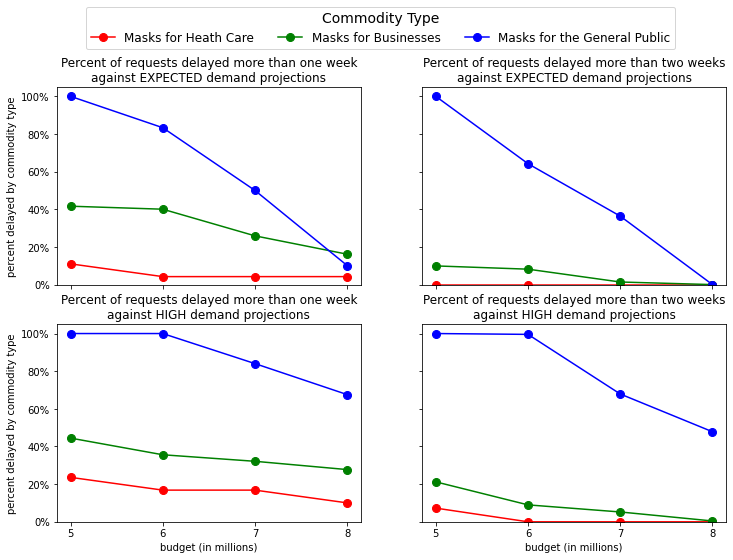

In [19]:
###create figures delays###

fig, axs = plot.subplots(2, 2, figsize=(12,8))

delay_calcs_df_summarised['budget_M'] = (delay_calcs_df_summarised['budget']/1000000)

for rely in reliability_levels:
    df1 = delay_calcs_df_summarised[delay_calcs_df_summarised['commodity_type'] == 1]
    df2 = delay_calcs_df_summarised[delay_calcs_df_summarised['commodity_type'] == 2]
    df3 = delay_calcs_df_summarised[delay_calcs_df_summarised['commodity_type'] == 3]
    y_axis_col_name = ['perc_delayed', 'perc_delayed_2']
    title_adj = ['Percent of requests delayed more than one week',\
                 'Percent of requests delayed more than two weeks']
    
    for n_delay in [0,1]:
        
        axs[rely-1, n_delay].yaxis.set_major_formatter(mtick.PercentFormatter())
        axs[rely-1, n_delay].set_xticks(np.arange(5,9,step = 1))
        axs[rely-1, n_delay].set(xlabel = 'budget (in millions)', \
                                 ylabel = 'percent delayed by commodity type')#title_adj[n_delay])
        axs[rely-1, n_delay].set(ylim=(0, 105))

        axs[rely-1, n_delay].plot('budget_M', y_axis_col_name[n_delay], 
                  data=df1[(df1['reliability_level'] == rely)],
                 marker = 'o', color = 'red', markersize=8, label = names_commodity_type[0])#: ' + r'$r_k = 1.0$')
        axs[rely-1, n_delay].plot('budget_M', y_axis_col_name[n_delay], 
                data=df2[(df2['reliability_level'] == rely)],
                marker = 'o', color = 'green', markersize=8, label = names_commodity_type[1])#'2: ' + r'$r_k = 0.5$')
        axs[rely-1, n_delay].plot('budget_M', y_axis_col_name[n_delay], 
                  data=df3[(df3['reliability_level'] == rely)],
                 marker = 'o', color = 'blue', markersize=8, label = names_commodity_type[2])#3: ' + r'$r_k = 0.2$')
        
        axs[rely-1, n_delay].set_title(title_adj[n_delay]+'\nagainst ' + reliability_level_names[rely-1])
        
for ax in fig.get_axes():
    ax.label_outer()
    
lines, labels = fig.axes[-1].get_legend_handles_labels()
    
fig.legend(lines, labels, loc = 'upper center', ncol = K_set, title = 'Commodity Type',
          bbox_to_anchor=(.5, 1.03), fontsize = 12, fancybox = True, title_fontsize=14)

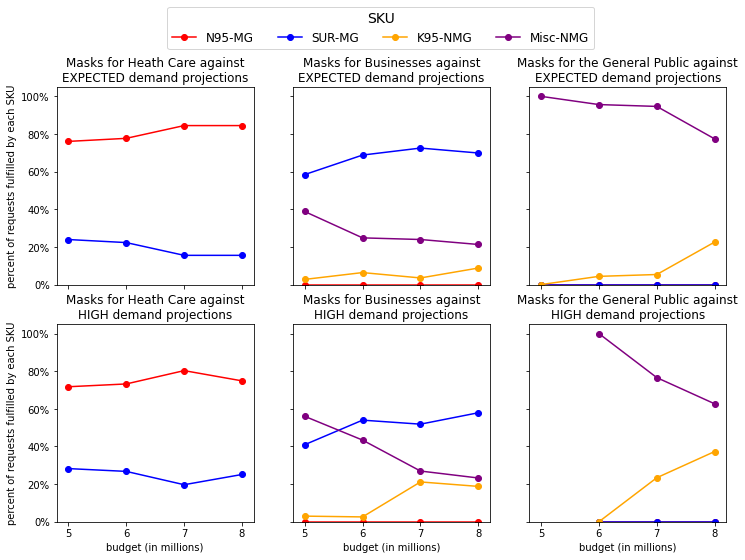

In [15]:
#### QUALITY IMPACTS #####

qual_df1 = fulfilled_df_plan[['reliability_level', 'budget',
                              'commodity_type', 'SKU', 'units_fulfilled']]\
.groupby(['reliability_level', 'budget', 'commodity_type', 'SKU']).sum().reset_index()

qual_df2 = qual_df1[['reliability_level', 'budget', 'commodity_type', 'units_fulfilled']]\
.groupby(['reliability_level', 'budget', 'commodity_type']).sum().reset_index()

qual_df3 = qual_df1.merge(qual_df2, 
           on = ['reliability_level', 
                 'budget', 'commodity_type'], how = 'left')

qual_df3['perc_of_total'] = \
(qual_df3['units_fulfilled_x']/qual_df3['units_fulfilled_y'])*100

#adjust budget to 1,000,000
qual_df3['budget'] = (qual_df3['budget']/1000000)


colors = ['red', 'blue', 'orange', 'purple']

###create figures SKUS ###
fig, axs = plot.subplots(2, 3, figsize=(12,8))

for rely in reliability_levels:
    for commodity in range(1,K_set+1):
        qual_df4 = qual_df3[(qual_df3['reliability_level'] == rely) & \
                            (qual_df3['commodity_type'] == commodity)]

        for SKU_temp in range(1,I_set+1):
            axs[rely-1, commodity-1].yaxis.set_major_formatter(mtick.PercentFormatter())
            axs[rely-1, commodity-1].set(ylim=(0, 105), xlim=(4.8,8.2))
            
            axs[rely-1, commodity-1].set(xlabel = 'budget (in millions)', \
                                 ylabel = 'percent of requests fulfilled by each SKU')
            
            qual_df5 = qual_df4[qual_df4['SKU'] == SKU_temp]
            
            if(int(SKU_temp) in I_k_dict.get(int(commodity))):
            
                axs[rely-1, commodity-1].plot('budget', 'perc_of_total',
                                              data = qual_df5,
                                              color = colors[SKU_temp-1],
                                              label = names_SKU[SKU_temp-1],
                                             marker = 'o')


                axs[rely-1, commodity-1].set_title(names_commodity_type[commodity-1]+' against\n'
                                                   + reliability_level_names[rely-1])
for ax in fig.get_axes():
    ax.label_outer()
    
lines, labels = fig.axes[-1].get_legend_handles_labels()
    
fig.legend(lines, labels, loc = 'upper center', ncol = I_set, title = 'SKU',
          bbox_to_anchor=(.5, 1.03), fontsize = 12, fancybox = True, title_fontsize=14)